In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from statsmodels.tsa.api import VAR


In [2]:
# Load yield data using pandas to handle non-numeric headers
df = pd.read_csv('UnsmFB_70_09.txt', delim_whitespace=True, comment='%', header=None)

# Set column names
column_names = [
    'Date', '3M', '6M', '9M', '12M', '15M', '18M', '21M', '24M', '30M', '36M', '48M', '60M', '72M', '84M', '96M', '108M', '120M'
]
df.columns = column_names

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

data = df.iloc[:, 1:].values  # Yield data
time = df['Date'].values   # Time index

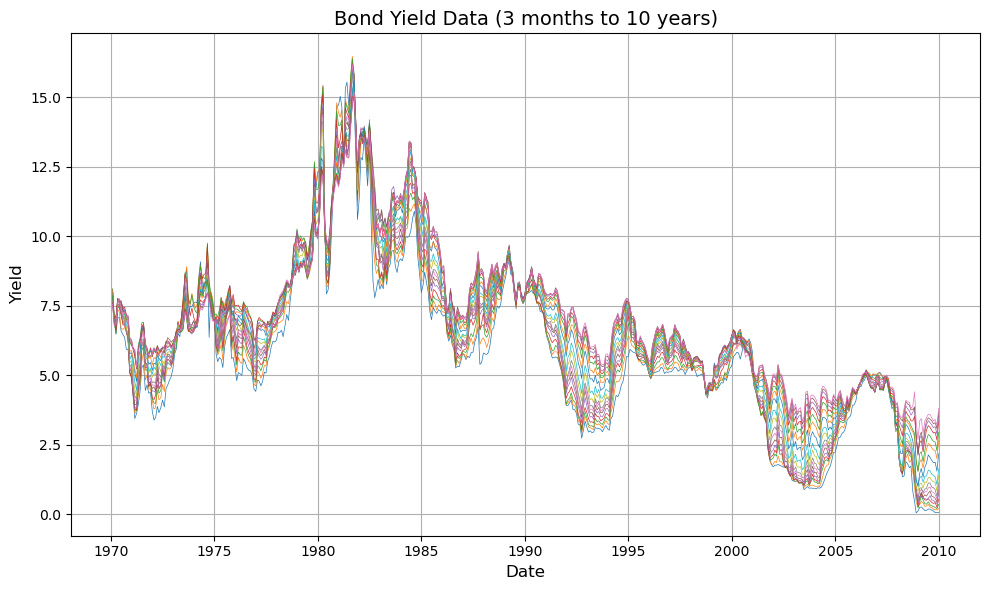

In [3]:
# Plot bond yield data
plt.figure(figsize=(10, 6))
plt.plot(time, data, linewidth=0.5)  # Thinner lines with linewidth=0.5
plt.title('Bond Yield Data (3 months to 10 years)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Yield', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('bond_yields.pdf', format='pdf')  # Save as PDF
plt.show()

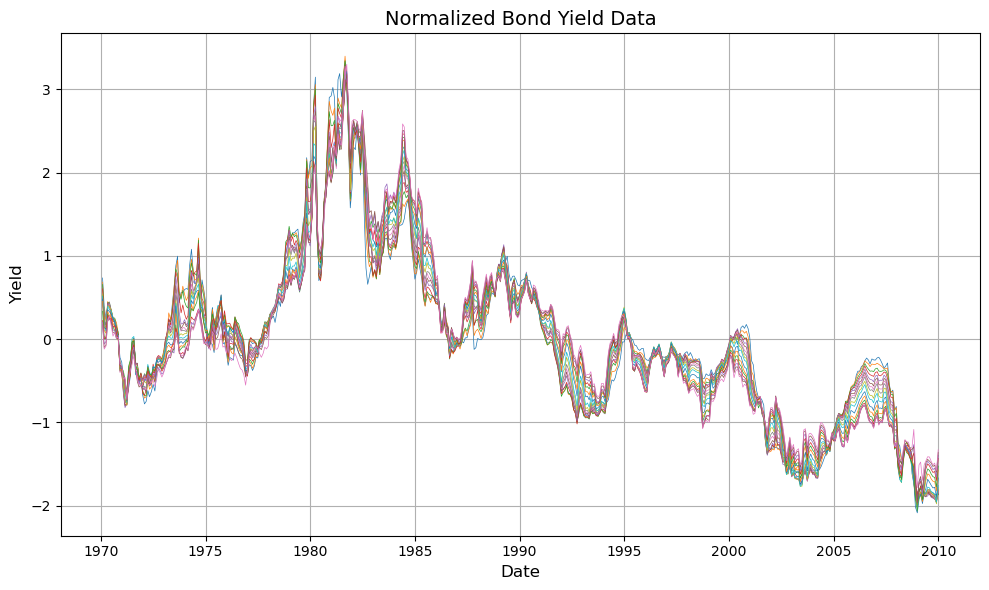

In [4]:
# Standardize data for analysis
scaler = StandardScaler()
data_norm = scaler.fit_transform(data)

plt.figure(figsize=(10, 6))
plt.plot(time, data_norm, linewidth=0.5)  # Thinner lines with linewidth=0.5
plt.title('Normalized Bond Yield Data', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Yield', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('bond_yields_norm.pdf', format='pdf')  # Save as PDF
plt.show()


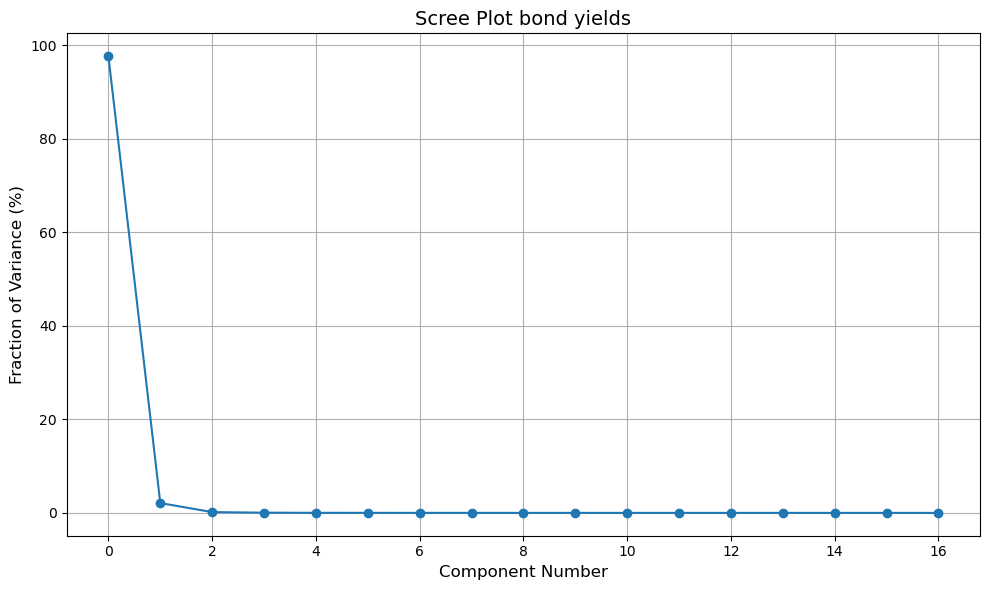

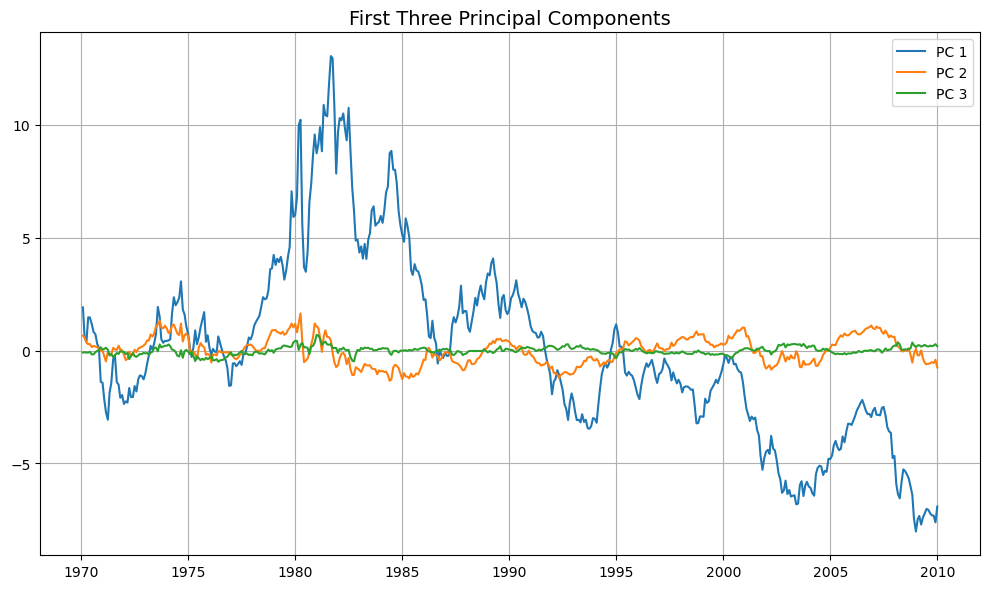

In [5]:
# Compute principal components of normalized data
pca = PCA()
factors = pca.fit_transform(data_norm)
eigenvalues = pca.explained_variance_

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(100 * eigenvalues / sum(eigenvalues), 'o-', linewidth=1.5)
plt.title('Scree Plot bond yields', fontsize=14)
plt.xlabel('Component Number', fontsize=12)
plt.ylabel('Fraction of Variance (%)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('scree_plot_yields.pdf', format='pdf')
plt.show()


# Plot the first three principal components
plt.figure(figsize=(10, 6))
plt.plot(time, factors[:, :3], linewidth=1.5)
plt.title('First Three Principal Components', fontsize=14)
plt.legend(['PC 1', 'PC 2', 'PC 3'])
plt.grid(True)
plt.tight_layout()
plt.savefig('3factors_yields.pdf', format='pdf')
plt.show()


In [6]:
# Compute fits using different numbers of principal components

fits = [pca.components_[:i].T @ factors[:, :i].T for i in range(1, 18)]
fits = [fit.T for fit in fits]


# Compute errors and Bai-Ng Criterion
errors = [data_norm - fit for fit in fits]
V = [np.sum(err**2) / err.size for err in errors]
term = np.sum(data_norm.shape) * np.log(min(data_norm.shape)) / data_norm.size
Bai_Ng_criterion = V + np.arange(1, len(V) + 1) * term

# Ahn and Horenstein Criterion
ahn_horenstein_criterion = eigenvalues[:-1] / eigenvalues[1:]

# Display criteria for choosing the number of factors
print('\nChoosing number of factors\n')
print('Factor #    Bai-Ng    Ahn-Horenstein')
print('====================================')
for i in range(10):
    print(f'{i+1:8d}    {Bai_Ng_criterion[i]:6.3f}        {ahn_horenstein_criterion[i]:6.3f}')



Choosing number of factors

Factor #    Bai-Ng    Ahn-Horenstein
       1     0.196        46.393
       2     0.348        12.263
       3     0.519         3.910
       4     0.691         3.104
       5     0.863         1.932
       6     1.036         1.242
       7     1.208         1.497
       8     1.381         1.275
       9     1.553         1.242
      10     1.726         1.298


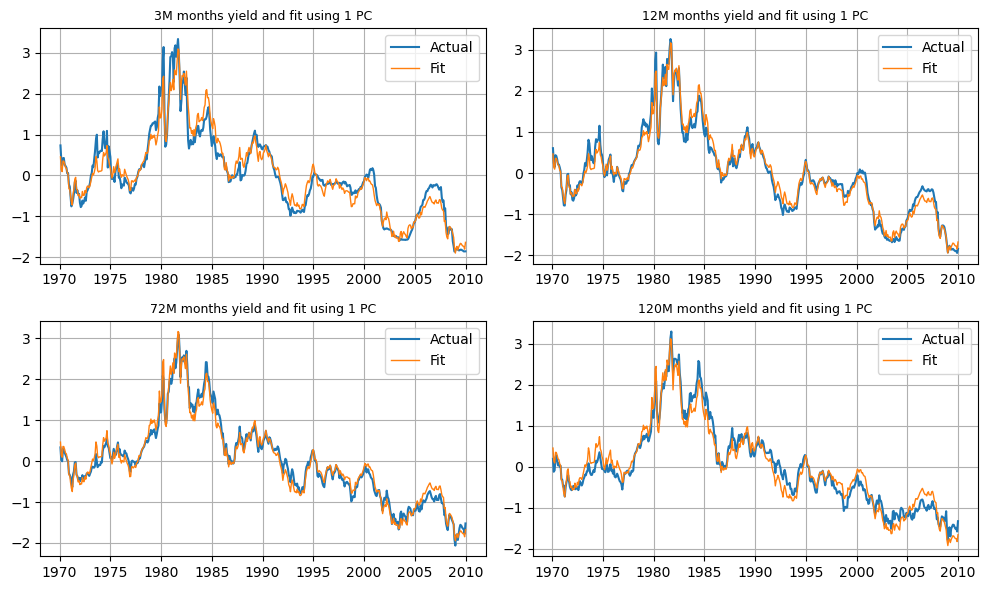

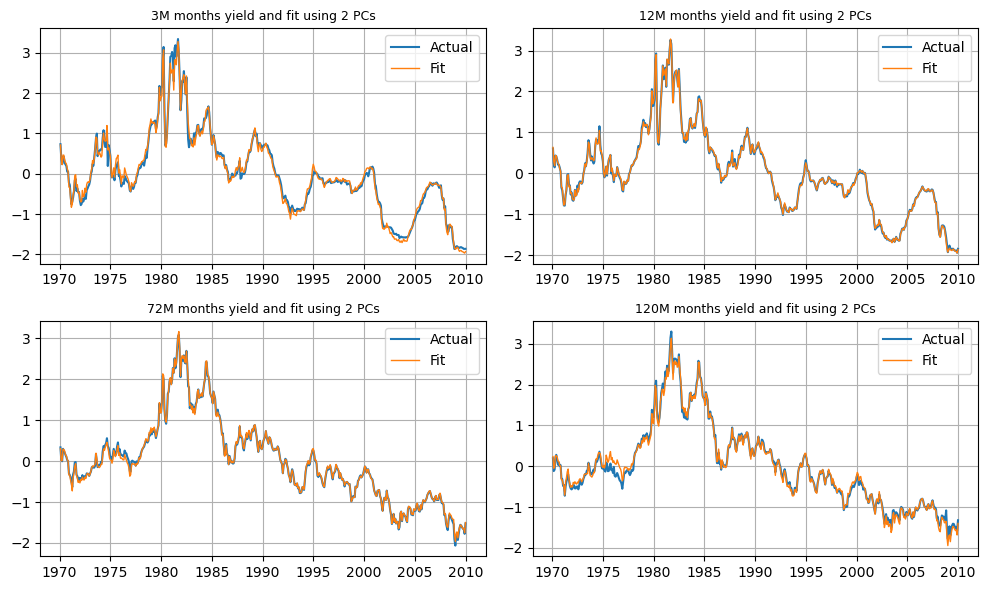

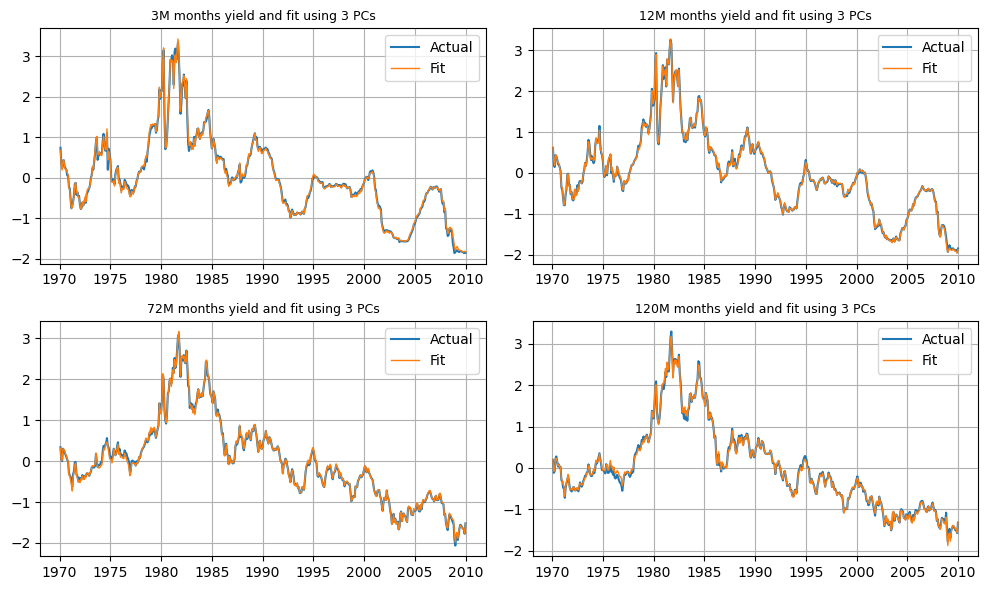

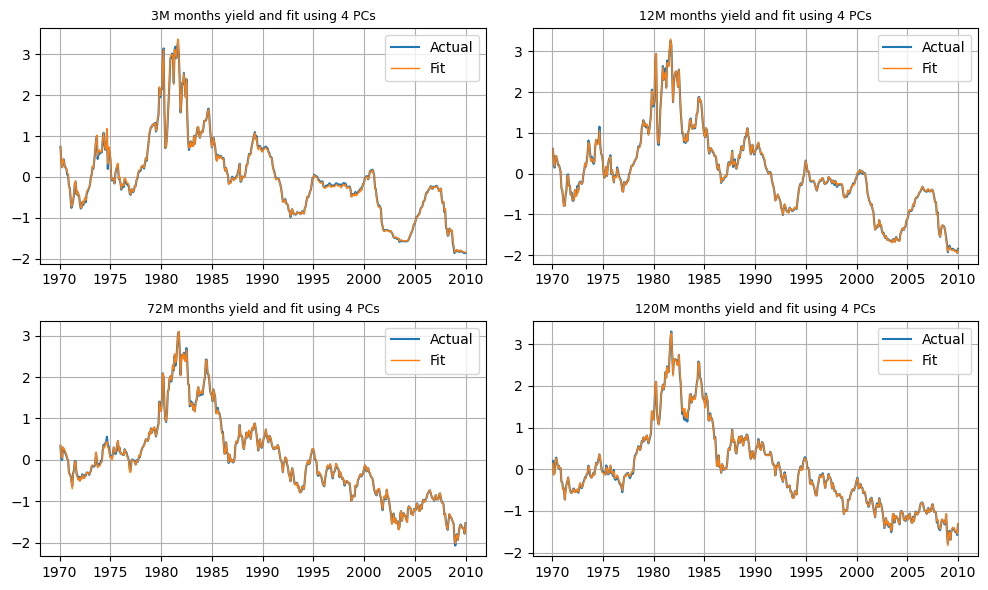

In [7]:
# Plot yields and fits for different numbers of principal components
maturities = [0, 3, 12, 16]  # Indices for 3 months, 12 months, 6 years, 10 years

for i, fit in enumerate(fits[:4], start=1):
    plt.figure(figsize=(10, 6))
    for j, mat in enumerate(maturities, start=1):
        plt.subplot(2, 2, j)
        plt.plot(time, data_norm[:, mat], label='Actual')
        plt.plot(time, fit[:, mat], label='Fit',linewidth=1)
        plt.title(f'{column_names[mat+1]} months yield and fit using {i} PC{"s" if i > 1 else ""}', fontsize=9)
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'fit_{i}factor.pdf', format='pdf')
    plt.show()


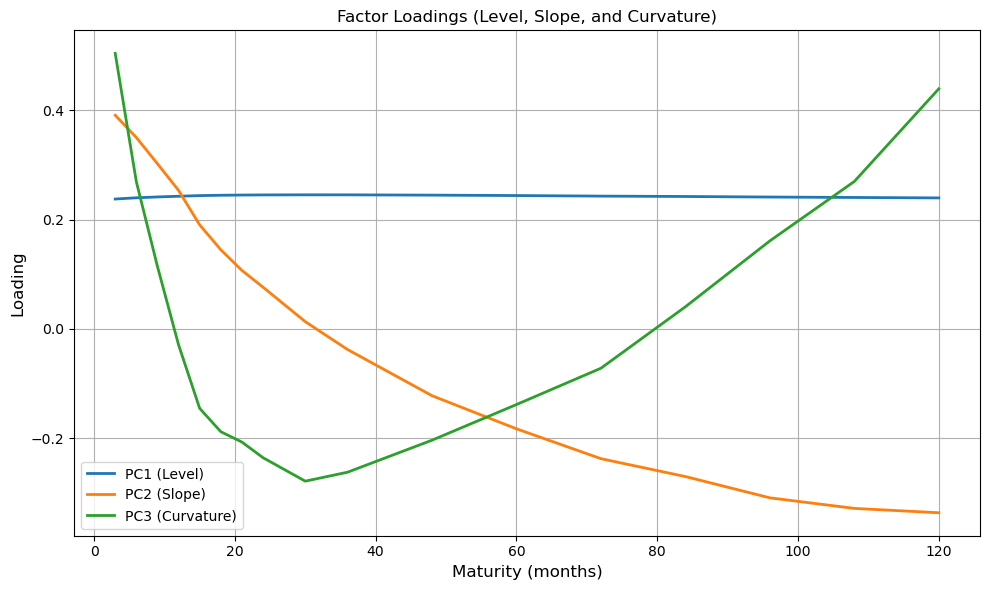

In [8]:
# Plot factor loadings
matur = np.array([3, 6, 9, 12, 15, 18, 21, 24, 30, 36, 48, 60, 72, 84, 96, 108, 120])

plt.figure(figsize=(10, 6))
plt.plot(matur, pca.components_[:3].T, linewidth=2)
plt.legend(['PC1 (Level)', 'PC2 (Slope)', 'PC3 (Curvature)'])
plt.title('Factor Loadings (Level, Slope, and Curvature)', fontsize=12)
plt.xlabel('Maturity (months)', fontsize=12)
plt.ylabel('Loading', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('factor_loadings.pdf', format='pdf')
plt.show()

In [9]:
# Estimate a VAR process for the 3 main factors
Lmax = 8  # Maximum number of lags to check for VAR order
model = VAR(factors[:, :3])

# Information criteria
aic, bic, hqic = [], [], []
for i in range(1, Lmax + 1):
    result = model.fit(i)
    aic.append(result.aic)
    bic.append(result.bic)
    hqic.append(result.hqic)

# Display information criteria
print('\nInformation Criteria\n')
print('Lag    AIC      BIC      HQIC')
print('=============================')
for i in range(Lmax):
    print(f'{i+1:3d}  {aic[i]:6.3f}   {bic[i]:6.3f}   {hqic[i]:6.3f}')

    



Information Criteria

Lag    AIC      BIC      HQIC
  1  -9.440   -9.335   -9.399
  2  -9.496   -9.313   -9.424
  3  -9.524   -9.262   -9.421
  4  -9.532   -9.190   -9.397
  5  -9.520   -9.099   -9.354
  6  -9.509   -9.009   -9.313
  7  -9.513   -8.932   -9.284
  8  -9.499   -8.839   -9.239


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Jul, 2024
Time:                     16:10:15
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -9.33518
Nobs:                     479.000    HQIC:                  -9.39860
Log likelihood:           233.791    FPE:                7.95053e-05
AIC:                     -9.43969    Det(Omega_mle):     7.75463e-05
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.018235         0.028546           -0.639           0.523
L1.y1         0.990979         0.007021          141.153           0.000
L1.y2         0.016985         0.047752            0.356           0.722
L1.y3         0.199347

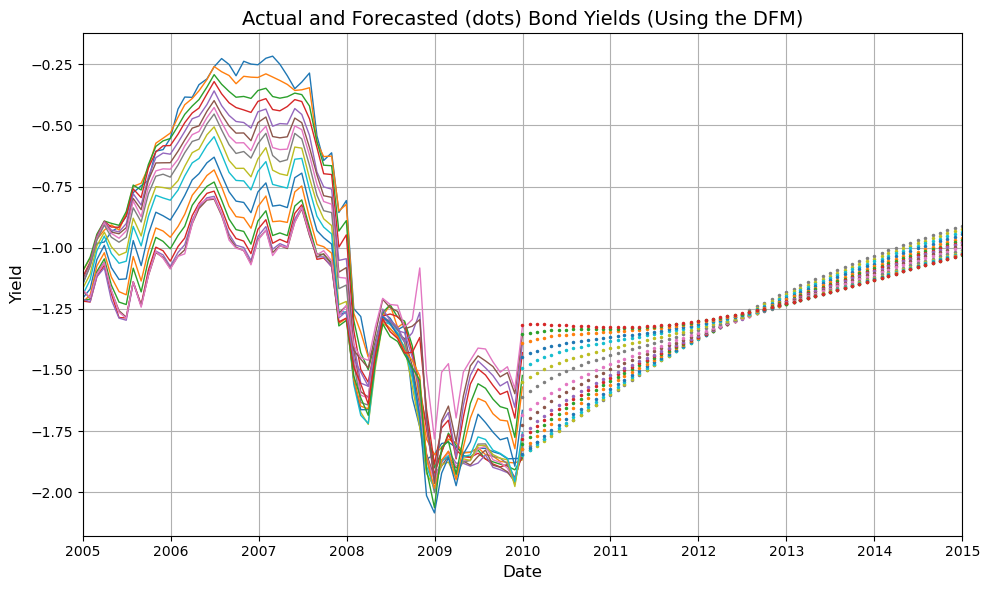

In [12]:
# Estimate first order VAR for forecasting exercise (just for illustration)
nlag = 1
fVAR = model.fit(nlag)

results = model.fit(1)
print(results.summary())


AA = fVAR.params[1:].T  # Matrix on lagged values



# Data transposed: column is date, row is yield
YY = data_norm.T

# We start forecasting at last day in sample. Let's call it T:
FT = factors[-1, :3]

fhorizon = 61# Maximum forecast horizon: 5 years
Yfore = np.zeros((YY.shape[0], fhorizon))

#for ih in range(1, fhorizon + 1):
#    Yfore[:, ih - 1] = pca.components_[:3].T @ np.linalg.matrix_power(AA.T, ih) @ FT
for i in range(fhorizon):
    FT = AA @ FT
    Yfore[:, i] = pca.components_[:3].T @ FT
    
    
# Plot actual and forecasted bond yields
time2 = pd.date_range(time[-1], periods=fhorizon, freq='M')
plt.figure(figsize=(10, 6))
plt.plot(time[415:], YY[:, 415:].T, label='Actual', linewidth=1)
plt.plot(time2, Yfore.T,'.', markersize=3, label='Forecast', linewidth=1)
plt.title('Actual and Forecasted (dots) Bond Yields (Using the DFM)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Yield', fontsize=12)
plt.xlim(pd.Timestamp('2005-01-01'), pd.Timestamp('2015-01-01'))

plt.grid(True)
plt.tight_layout()
plt.savefig('yields_forecasts.pdf', format='pdf')
plt.show()